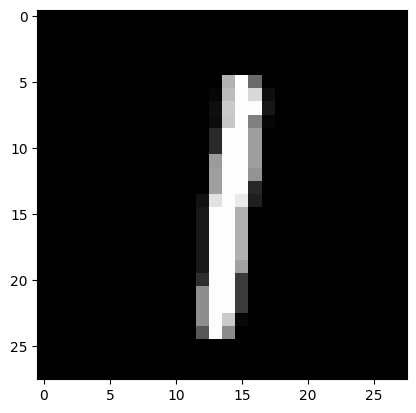

(28, 28)
(26, 26, 32)


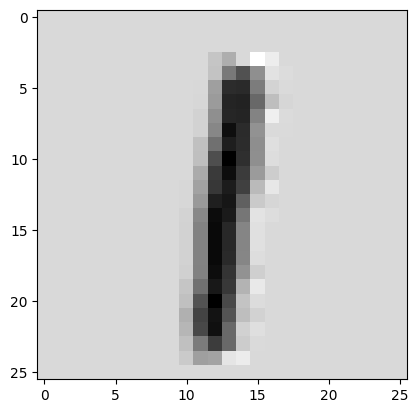

<Figure size 640x480 with 0 Axes>

In [20]:
import numpy as np

class ConvolutionLayer:
    def __init__(self, kernel_num, kernel_size):
        """
        Constructor takes as input the number of kernels and their size. I assume only squared filters of size kernel_size x kernel_size
        """
        self.kernel_num = kernel_num
        self.kernel_size = kernel_size
        # Generate random filters of shape (kernel_num, kernel_size, kernel_size). Divide by kernel_size^2 for weight normalization
        self.kernels = np.random.randn(kernel_num, kernel_size, kernel_size) / (kernel_size**2)

    def patches_generator(self, image):
        """
        Divide the input image in patches to be used during convolution.
        Yields the tuples containing the patches and their coordinates.
        """
        # Extract image height and width
        image_h, image_w = image.shape
        self.image = image
        # The number of patches, given a fxf filter is h-f+1 for height and w-f+1 for width
        for h in range(image_h-self.kernel_size+1):
            for w in range(image_w-self.kernel_size+1):
                patch = image[h:(h+self.kernel_size), w:(w+self.kernel_size)]
                yield patch, h, w
    
    def forward_prop(self, image):
        """
        Perform forward propagation for the convolutional layer.
        """
        # Extract image height and width
        image_h, image_w = image.shape
        # Initialize the convolution output volume of the correct size
        convolution_output = np.zeros((image_h-self.kernel_size+1, image_w-self.kernel_size+1, self.kernel_num))
        # Unpack the generator
        for patch, h, w in self.patches_generator(image):
            # Perform convolution for each patch
            convolution_output[h,w] = np.sum(patch*self.kernels, axis=(1,2))
        return convolution_output
    
    def back_prop(self, dE_dY, alpha):
        """
        Takes the gradient of the loss function with respect to the output and computes the gradients of the loss function with respect
        to the kernels' weights.
        dE_dY comes from the following layer, typically max pooling layer.
        It updates the kernels' weights
        """
        # Initialize gradient of the loss function with respect to the kernel weights
        dE_dk = np.zeros(self.kernels.shape)
        for patch, h, w in self.patches_generator(self.image):
            for f in range(self.kernel_num):
                dE_dk[f] += patch * dE_dY[h, w, f]
        # Update the parameters
        self.kernels -= alpha*dE_dk
        return dE_dk

class MaxPoolingLayer:
    def __init__(self, kernel_size):
        """
        Constructor takes as input the size of the kernel
        """
        self.kernel_size = kernel_size

    def patches_generator(self, image):
        """
        Divide the input image in patches to be used during pooling.
        Yields the tuples containing the patches and their coordinates.
        """
        # Compute the ouput size
        output_h = image.shape[0] // self.kernel_size
        output_w = image.shape[1] // self.kernel_size
        self.image = image

        for h in range(output_h):
            for w in range(output_w):
                patch = image[(h*self.kernel_size):(h*self.kernel_size+self.kernel_size), (w*self.kernel_size):(w*self.kernel_size+self.kernel_size)]
                yield patch, h, w

    def forward_prop(self, image):
        image_h, image_w, num_kernels = image.shape
        max_pooling_output = np.zeros((image_h//self.kernel_size, image_w//self.kernel_size, num_kernels))
        for patch, h, w in self.patches_generator(image):
            max_pooling_output[h,w] = np.amax(patch, axis=(0,1))
        return max_pooling_output

    def back_prop(self, dE_dY):
        """
        Takes the gradient of the loss function with respect to the output and computes the gradients of the loss function with respect
        to the kernels' weights.
        dE_dY comes from the following layer, typically softmax.
        There are no weights to update, but the output is needed to update the weights of the convolutional layer.
        """
        dE_dk = np.zeros(self.image.shape)
        for patch,h,w in self.patches_generator(self.image):
            image_h, image_w, num_kernels = patch.shape
            max_val = np.amax(patch, axis=(0,1))

            for idx_h in range(image_h):
                for idx_w in range(image_w):
                    for idx_k in range(num_kernels):
                        if patch[idx_h,idx_w,idx_k] == max_val[idx_k]:
                            dE_dk[h*self.kernel_size+idx_h, w*self.kernel_size+idx_w, idx_k] = dE_dY[h,w,idx_k]
            return dE_dk

class SoftmaxLayer:
    """
    Takes the volume coming from convolutional & pooling layers. It flattens it and it uses it in the next layers.
    """
    def __init__(self, input_units, output_units):
        # Initiallize weights and biases
        self.weight = np.random.randn(input_units, output_units)/input_units
        self.bias = np.zeros(output_units)

    def forward_prop(self, image):
        self.original_shape = image.shape # stored for backprop
        # Flatten the image
        image_flattened = image.flatten()
        self.flattened_input = image_flattened # stored for backprop
        # Perform matrix multiplication and add bias
        first_output = np.dot(image_flattened, self.weight) + self.bias
        self.output = first_output
        # Apply softmax activation
        softmax_output = np.exp(first_output) / np.sum(np.exp(first_output), axis=0)
        return softmax_output

    def back_prop(self, dE_dY, alpha):
        for i, gradient in enumerate(dE_dY):
            if gradient == 0:
                continue
            transformation_eq = np.exp(self.output)
            S_total = np.sum(transformation_eq)

            # Compute gradients with respect to output (Z)
            dY_dZ = -transformation_eq[i]*transformation_eq / (S_total**2)
            dY_dZ[i] = transformation_eq[i]*(S_total - transformation_eq[i]) / (S_total**2)

            # Compute gradients of output Z with respect to weight, bias, input
            dZ_dw = self.flattened_input
            dZ_db = 1
            dZ_dX = self.weight

            # Gradient of loss with respect ot output
            dE_dZ = gradient * dY_dZ

            # Gradient of loss with respect to weight, bias, input
            dE_dw = dZ_dw[np.newaxis].T @ dE_dZ[np.newaxis]
            dE_db = dE_dZ * dZ_db
            dE_dX = dZ_dX @ dE_dZ

            # Update parameters
            self.weight -= alpha*dE_dw
            self.bias -= alpha*dE_db

            return dE_dX.reshape(self.original_shape)

def CNN_forward(image, label, layers):
    output = image/255.
    for layer in layers:
        output = layer.forward_prop(output)
    # Compute loss (cross-entropy) and accuracy
    loss = -np.log(output[label])
    accuracy = 1 if np.argmax(output) == label else 0
    return output, loss, accuracy

def CNN_backprop(gradient, layers, alpha=0.05):
    grad_back = gradient
    for layer in layers[::-1]:
        if type(layer) in [ConvolutionLayer, SoftmaxLayer]:
            grad_back = layer.back_prop(grad_back, alpha)
        elif type(layer) == MaxPoolingLayer:
            grad_back = layer.back_prop(grad_back)
    return grad_back


def CNN_training(image, label, layers, alpha=0.05):
    # Forward step
    output, loss, accuracy = CNN_forward(image, label, layers)

    # Initial gradient
    gradient = np.zeros(10)
    gradient[label] = -1/output[label]

    # Backprop step
    gradient_back = CNN_backprop(gradient, layers, alpha)

    return loss, accuracy





import pandas as pd
import matplotlib.pyplot as plt
#Test the convolutions with 1 image, to put in the article
# Test
df_train = pd.read_csv('dataset/mnist/mnist_train.csv')
img = df_train.iloc[40,:].values[1:]
img = np.reshape(img,(28,28))
plt.imshow(img, cmap='gray')
plt.show()
print(img.shape)
plt.savefig('images/original_image.png', format='png', dpi=1200)

# Test with a convolution of 16 filters of size 3x3
my_conv = ConvolutionLayer(32,3)
output = my_conv.forward_prop(img)
# See the dimensions of the output volume, they follow the usual formula
print(output.shape)

# Plot 16th volume after the convolution
plt.imshow(output[:,:,15], cmap='gray')
plt.show()
plt.savefig('images/image_convolved.png', format='png', dpi=1200)
